# Watershed distance transform with foreground and background separation
---
Implementation of papers:

[Deep Watershed Transform for Instance Segmentation](http://openaccess.thecvf.com/content_cvpr_2017/papers/Bai_Deep_Watershed_Transform_CVPR_2017_paper.pdf)

[Learn to segment single cells with deep distance estimator and deep cell detector](https://arxiv.org/abs/1803.10829)

In [1]:
import os
import errno

import numpy as np
from skimage.external import tifffile as tiff
from tensorflow.python.keras.optimizers import SGD, Adam
from tensorflow.python.keras import backend as K

from deepcell import get_data
from deepcell import make_training_data
from deepcell import rate_scheduler
from deepcell.model_zoo import bn_feature_net_61x61
from deepcell.model_zoo import bn_feature_net_2D
from deepcell.model_zoo import bn_feature_net_skip_2D

from deepcell.training import train_model_conv
from deepcell.training import train_model_sample

Using TensorFlow backend.


## Load the Training Data

In [2]:
RESIZE = True
RESHAPE_SIZE = 256
BINS = 4
EROSION = 0

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/unspecified_nuclear_data/nuclei_broad'
DATA_FILE = 'nuclei_broad_watershed'

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'

ROW_AXIS = 2 if IS_CHANNELS_FIRST else 1
COL_AXIS = 3 if IS_CHANNELS_FIRST else 2
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else -1

WIN_X = 30
WIN_Y = 30

# create these directories if they do not exist
for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
    try:
        os.makedirs(os.path.join(d, PREFIX))
        print('Created new directory:', os.path.join(d, PREFIX))
    except OSError as exc: # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

In [3]:
# Make the training data for watershed distance transform
make_training_data(
    direc_name=os.path.join(DATA_DIR, PREFIX),
    dimensionality=2,
    file_name_save=os.path.join(NPZ_DIR, PREFIX, DATA_FILE),
    training_direcs=['set1', 'set2', 'set3', 'set4', 'set5'],
    channel_names=['nuclear'],
    num_of_features=BINS,
    raw_image_direc='processed',
    annotation_direc='annotated',
    reshape_size=RESHAPE_SIZE if RESIZE else None)

if os.path.isfile(os.path.join(NPZ_DIR, PREFIX, DATA_FILE) + '.npz'):
    print('Data Saved to', os.path.join(NPZ_DIR, PREFIX, DATA_FILE) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')

Reshaped feature data from (5, 520, 696, 1) to (45, 256, 256, 1)
Reshaped training data from (5, 520, 696, 1) to (45, 256, 256, 1)
Data Saved to /data/npz_data/cells/unspecified_nuclear_data/nuclei_broad/nuclei_broad_watershed.npz


## Conv Based Training

In [4]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# save the size of the input data for input_shape model parameter
size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[ROW_AXIS:COL_AXIS + 1]
if IS_CHANNELS_FIRST:
    input_shape = (X.shape[CHANNEL_AXIS], size[0], size[1])
else:
    input_shape = (size[0], size[1], X.shape[CHANNEL_AXIS])
    
# Set up other training parameters
n_epoch = 10
batch_size = 1
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)

X.shape: (45, 256, 256, 1)
y.shape: (45, 256, 256, 1)


In [5]:
# First, create a foreground/background separation model

# Instantiate the model
fgbg_model = bn_feature_net_skip_2D(
    receptive_field=61,
    n_skips=2,
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=input_shape,
    multires=False,
    last_only=False)

# Train the model
train_model_conv(
    model=fgbg_model,
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    transform=None,  # fg/bg separation
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    expt='conv_fgbg',
    lr_sched=lr_sched,
    skip=2,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (40, 256, 256, 1)
y_train shape: (40, 256, 256, 1)
X_test shape: (5, 256, 256, 1)
y_test shape: (5, 256, 256, 1)
Output Shape: (None, 256, 256, 2)
Number of Classes: 2
Epoch 1/10
39/40 [============================>.] - ETA: 0s - loss: 0.4825 - model_1_loss: 0.1453 - model_2_loss: 0.1748 - model_3_loss: 0.1415 - model_1_acc: 0.8882 - model_2_acc: 0.8838 - model_3_acc: 0.8819
Epoch 00001: val_loss improved from inf to 0.88863, saving model to /data/models/cells/unspecified_nuclear_data/nuclei_broad/2018-08-31_nuclei_broad_watershed_conv_fgbg.h5
40/40 [==============================] - 11s 276ms/step - loss: 0.4757 - model_1_loss: 0.1427 - model_2_loss: 0.1722 - model_3_loss: 0.1399 - model_1_acc: 0.8891 - model_2_acc: 0.8843 - model_3_acc: 0.8823 - val_loss: 0.8886 - val_model_1_loss: 0.3063 - val_model_2_loss: 0.2858 - val_model_3_loss: 0.2756 - val_model_1_acc: 0.9584 - val_model_2_acc: 0.8794 - val_model_3_acc: 0.8689
Epoch 2/10
39/40 [============================>.] -

In [6]:
# Next, Create a model for the watershed energy transform

# Instantiate the model
watershed_model = bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    receptive_field=61,
    n_skips=2,
    n_features=BINS,
    n_conv_filters=32,
    n_dense_filters=128,
    multires=False,
    last_only=False,
    input_shape=input_shape)

# Train the model
train_model_conv(
    model=watershed_model,
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    skip=2,
    transform='watershed',
    distance_bins=BINS,
    erosion_width=EROSION,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    expt='conv_watershed',
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (40, 256, 256, 1)
y_train shape: (40, 256, 256, 1)
X_test shape: (5, 256, 256, 1)
y_test shape: (5, 256, 256, 1)
Output Shape: (None, 256, 256, 4)
Number of Classes: 4
Epoch 1/10
39/40 [============================>.] - ETA: 0s - loss: 2.0145 - model_5_loss: 0.6648 - model_6_loss: 0.6676 - model_7_loss: 0.6402 - model_5_acc: 0.7339 - model_6_acc: 0.7429 - model_7_acc: 0.7451
Epoch 00001: val_loss improved from inf to 3.65018, saving model to /data/models/cells/unspecified_nuclear_data/nuclei_broad/2018-08-31_nuclei_broad_watershed_conv_watershed.h5
40/40 [==============================] - 14s 338ms/step - loss: 1.9948 - model_5_loss: 0.6583 - model_6_loss: 0.6605 - model_7_loss: 0.6341 - model_5_acc: 0.7363 - model_6_acc: 0.7453 - model_7_acc: 0.7474 - val_loss: 3.6502 - val_model_5_loss: 1.6467 - val_model_6_loss: 0.9902 - val_model_7_loss: 0.9713 - val_model_5_acc: 0.6915 - val_model_6_acc: 0.7938 - val_model_7_acc: 0.8106
Epoch 2/10
39/40 [============================

In [7]:
# With the trained model, make predictions on testing data
training_data_file = os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz')

train_dict, test_dict = get_data(training_data_file, mode='conv', seed=21)

X_test, y_test = test_dict['X'], test_dict['y']

test_images = watershed_model.predict(X_test)[-1]
test_images_fgbg = fgbg_model.predict(X_test)[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=CHANNEL_AXIS)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=CHANNEL_AXIS)

print('watershed argmax shape:', argmax_images.shape)

watershed transform shape: (5, 256, 256, 4)
segmentation mask shape: (5, 256, 256, 2)
watershed argmax shape: (5, 256, 256, 1)


In [8]:
# threshold the foreground/background
# and remove back ground from watershed transform
if IS_CHANNELS_FIRST:
    fg_thresh = test_images_fgbg[:, 1, :, :] > 0.5
else:
    fg_thresh = test_images_fgbg[:, :, :, 1] > 0.5

fg_thresh = np.expand_dims(fg_thresh.astype(np.int16), axis=CHANNEL_AXIS)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [9]:
# Apply watershed method with the distance transform as seed
from scipy import ndimage
from skimage.morphology import watershed
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    if IS_CHANNELS_FIRST:
        image = fg_thresh[i, 0, :, :]
        distance = argmax_images_post_fgbg[i, 0, :, :]
    else:
        image = fg_thresh[i, :, :, 0]
        distance = argmax_images_post_fgbg[i, :, :, 0]

    local_maxi = peak_local_max(test_images[i, :, :, -1], min_distance=15, 
                                exclude_border=False, indices=False, labels=image)

    markers = ndimage.label(local_maxi)[0]
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=CHANNEL_AXIS)

## Plot the Results

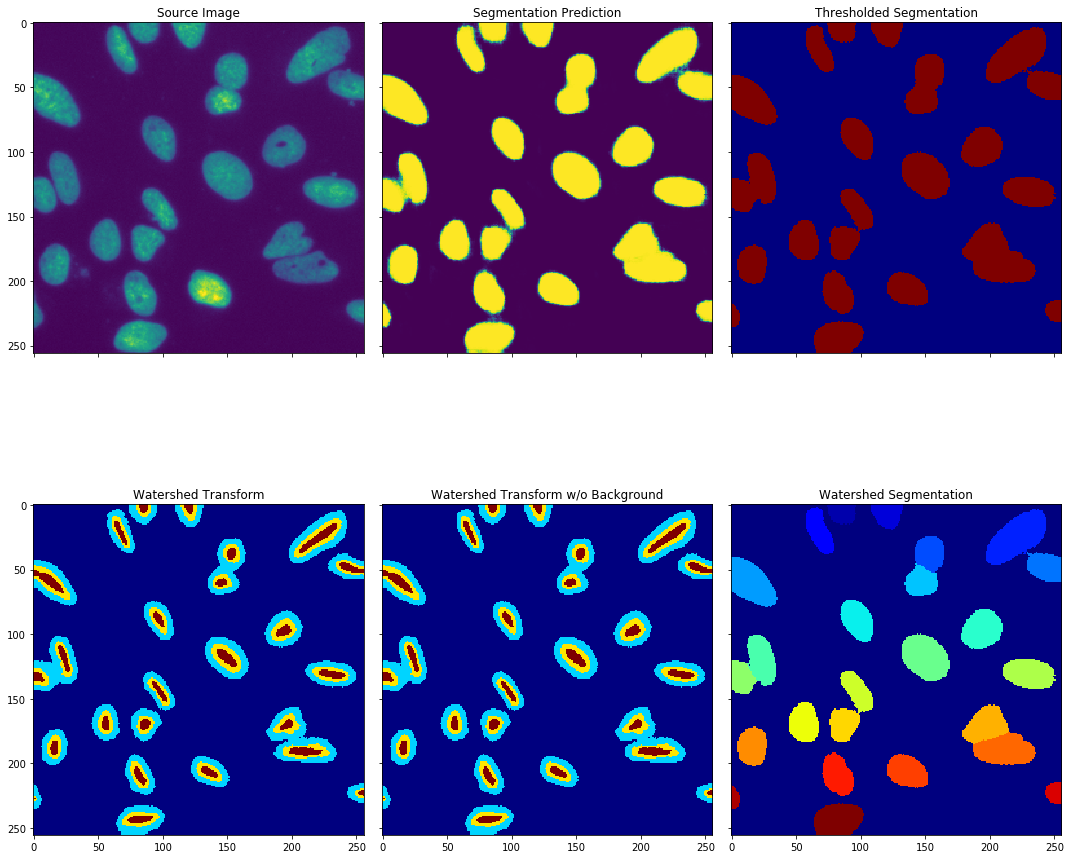

In [10]:
import matplotlib.pyplot as plt

index = 0

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, :, :, 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, :, :, 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, :, :, 0], cmap='jet')
ax[2].set_title('Thresholded Segmentation')

ax[3].imshow(argmax_images[index, :, :, 0], cmap='jet')
ax[3].set_title('Watershed Transform')

ax[4].imshow(argmax_images_post_fgbg[index, :, :, 0], cmap='jet')
ax[4].set_title('Watershed Transform w/o Background')

ax[5].imshow(watershed_images[index, :, :, 0], cmap='jet')
ax[5].set_title('Watershed Segmentation')

fig.tight_layout()
plt.show()

# Sample Based Training

In [13]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# save the size of the input data for input_shape model parameter
size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[ROW_AXIS:COL_AXIS + 1]
if IS_CHANNELS_FIRST:
    input_shape = (X.shape[CHANNEL_AXIS], size[0], size[1])
else:
    input_shape = (size[0], size[1], X.shape[CHANNEL_AXIS])
    
# Sample window dimensions
WIN_X = 30
WIN_Y = 30
    
# Set up other training parameters
n_epoch = 3
batch_size = 32
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)

X.shape: (45, 256, 256, 1)
y.shape: (45, 256, 256, 1)


In [14]:
# First, create a foreground/background separation model

# Instantiate the model
fgbg_model = bn_feature_net_2D(
    receptive_field=WIN_X + WIN_Y + 1,
    n_features=2)

# Train the model
train_model_sample(
    model=fgbg_model,
    dataset=DATA_FILE,
    optimizer=optimizer,
    window_size=(WIN_X, WIN_Y),
    batch_size=batch_size,
    transform=None,  # fg/bg separation
    n_epoch=n_epoch,
    balance_classes=True,
    max_class_samples=None,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    expt='sample_fgbg',
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (40, 256, 256, 1)
y_train shape: (40, 256, 256, 1)
X_test shape: (5, 256, 256, 1)
y_test shape: (5, 256, 256, 1)
Output Shape: (None, 2)
Number of Classes: 2
Epoch 1/3
17117/17120 [============================>.] - ETA: 0s - loss: 0.1125 - acc: 0.9544
Epoch 00001: val_loss improved from inf to 0.06594, saving model to /data/models/cells/unspecified_nuclear_data/nuclei_broad/2018-08-31_nuclei_broad_watershed_sample_fgbg.h5
17120/17120 [==============================] - 358s 21ms/step - loss: 0.1125 - acc: 0.9544 - val_loss: 0.0659 - val_acc: 0.9648
Epoch 2/3
17117/17120 [============================>.] - ETA: 0s - loss: 0.1065 - acc: 0.9567
Epoch 00002: val_loss improved from 0.06594 to 0.06240, saving model to /data/models/cells/unspecified_nuclear_data/nuclei_broad/2018-08-31_nuclei_broad_watershed_sample_fgbg.h5
17120/17120 [==============================] - 340s 20ms/step - loss: 0.1065 - acc: 0.9567 - val_loss: 0.0624 - val_acc: 0.9708
Epoch 3/3
17119/17120 [========

In [15]:
# Next, Create a model for the watershed energy transform

# Instantiate the model
watershed_model = bn_feature_net_2D(
    receptive_field=WIN_X + WIN_Y + 1,
    n_features=BINS)

# Train the model
train_model_sample(
    model=watershed_model,
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    window_size=(WIN_X, WIN_Y),
    transform='watershed',
    distance_bins=BINS,
    erosion_width=EROSION,
    balance_classes=True,
    max_class_samples=None,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    expt='sample_watershed',
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (40, 256, 256, 1)
y_train shape: (40, 256, 256, 1)
X_test shape: (5, 256, 256, 1)
y_test shape: (5, 256, 256, 1)
Output Shape: (None, 4)
Number of Classes: 4
Epoch 1/3
3887/3888 [============================>.] - ETA: 0s - loss: 0.5388 - acc: 0.7223
Epoch 00001: val_loss improved from inf to 0.22857, saving model to /data/models/cells/unspecified_nuclear_data/nuclei_broad/2018-08-31_nuclei_broad_watershed_sample_watershed.h5
3888/3888 [==============================] - 107s 28ms/step - loss: 0.5388 - acc: 0.7223 - val_loss: 0.2286 - val_acc: 0.9136
Epoch 2/3
3887/3888 [============================>.] - ETA: 0s - loss: 0.5044 - acc: 0.7392
Epoch 00002: val_loss improved from 0.22857 to 0.22473, saving model to /data/models/cells/unspecified_nuclear_data/nuclei_broad/2018-08-31_nuclei_broad_watershed_sample_watershed.h5
3888/3888 [==============================] - 104s 27ms/step - loss: 0.5044 - acc: 0.7392 - val_loss: 0.2247 - val_acc: 0.9014
Epoch 3/3
3886/3888 [========

In [16]:
# Re-initializing dilated models for sample-mode predictions
model_fn = bn_feature_net_61x61
watershed_weights_file = '2018-08-31_nuclei_broad_watershed_sample_watershed.h5'
watershed_weights_file = os.path.join(MODEL_DIR, PREFIX, watershed_weights_file)

fg_bg_weights_file = '2018-08-31_nuclei_broad_watershed_sample_fgbg.h5'
fg_bg_weights_file = os.path.join(MODEL_DIR, PREFIX, fg_bg_weights_file)

run_watershed_model = bn_feature_net_2D(
    receptive_field=WIN_X + WIN_Y + 1,
    dilated=True,
    n_features=BINS,
    input_shape=input_shape)
run_watershed_model.load_weights(watershed_weights_file)

run_fgbg_model = bn_feature_net_2D(
    receptive_field=WIN_X + WIN_Y + 1,
    dilated=True,
    n_features=2,
    input_shape=input_shape)
run_fgbg_model.load_weights(fg_bg_weights_file)

In [17]:
# With the trained model, make predictions on testing data
training_data_file = os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz')

train_dict, test_dict = get_data(training_data_file, mode='conv', seed=21)

X_test, y_test = test_dict['X'], test_dict['y']

test_images = run_watershed_model.predict(X_test)
test_images_fgbg = run_fgbg_model.predict(X_test)

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

argmax_images = []
for i in range(test_images.shape[0]):
    argmax_images.append(np.argmax(test_images[i], axis=CHANNEL_AXIS))
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=CHANNEL_AXIS)

print('watershed argmax shape:', argmax_images.shape)

watershed transform shape: (5, 256, 256, 4)
segmentation mask shape: (5, 256, 256, 2)
watershed argmax shape: (5, 256, 256, 1)


In [18]:
# threshold the foreground/background
# and remove back ground from watershed transform
if IS_CHANNELS_FIRST:
    fg_thresh = test_images_fgbg[:, 1, :, :] > 0.9
else:
    fg_thresh = test_images_fgbg[:, :, :, 1] > 0.9

fg_thresh = np.expand_dims(fg_thresh, axis=CHANNEL_AXIS)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [19]:
# Apply watershed method with the distance transform as seed
from scipy import ndimage
from skimage.morphology import watershed
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    if IS_CHANNELS_FIRST:
        image = fg_thresh[i, 0, :, :]
        distance = argmax_images_post_fgbg[i, 0, :, :]
    else:
        image = fg_thresh[i, :, :, 0]
        distance = argmax_images_post_fgbg[i, :, :, 0]

    local_maxi = peak_local_max(test_images[i, :, :, -1], min_distance=15, 
                                exclude_border=False, indices=False, labels=image)

    markers = ndimage.label(local_maxi)[0]
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=CHANNEL_AXIS)

## Plot the Results

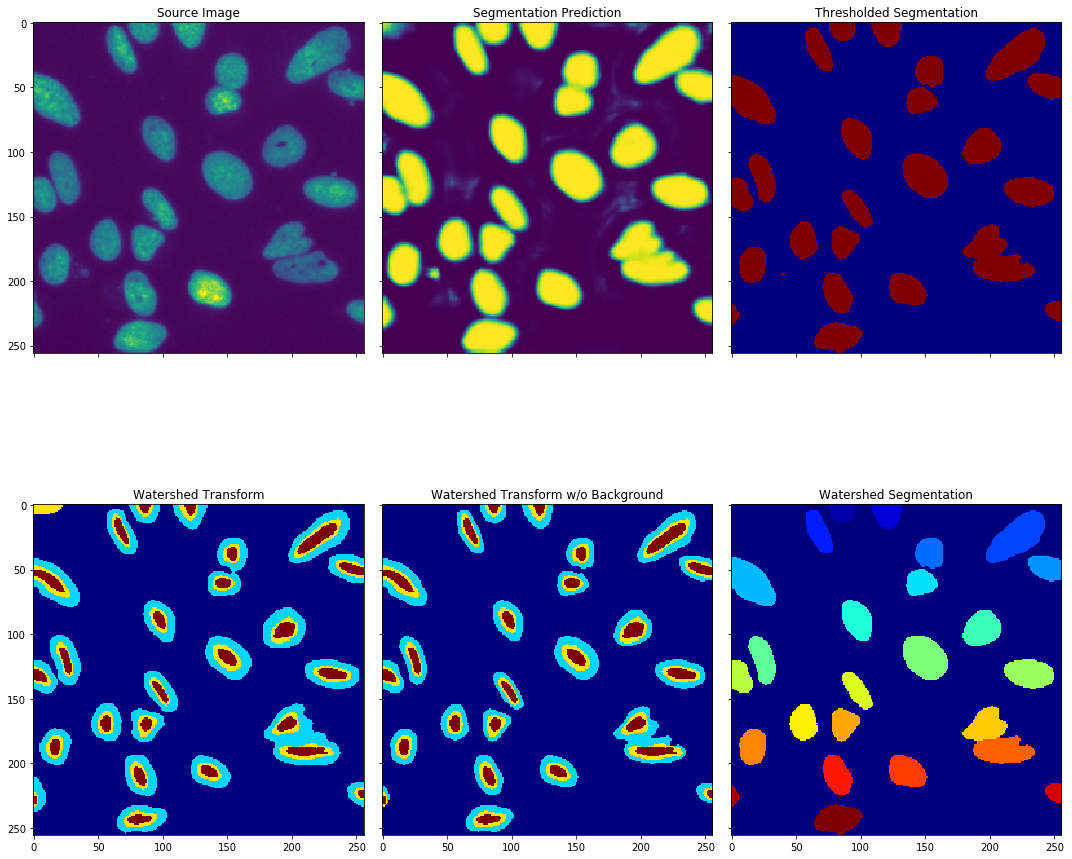

In [20]:
import matplotlib.pyplot as plt

index = 0

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, :, :, 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, :, :, 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, :, :, 0], cmap='jet')
ax[2].set_title('Thresholded Segmentation')

ax[3].imshow(argmax_images[index, :, :, 0], cmap='jet')
ax[3].set_title('Watershed Transform')

ax[4].imshow(argmax_images_post_fgbg[index, :, :, 0], cmap='jet')
ax[4].set_title('Watershed Transform w/o Background')

ax[5].imshow(watershed_images[index, :, :, 0], cmap='jet')
ax[5].set_title('Watershed Segmentation')

fig.tight_layout()
plt.show()